# Conjoint Analysis 
### Authors: Eu Jin Lok, Belén Sánchez Hidalgo

Conjoint analysis is widely used tool used in marketing research for new product development testing. It's usually executed as an online survey format with a few survey respondents will make 1 choice out of a set of different alternatives. The output allows researches to accurately identify what product features and combination works best before developing them

This notebook outlines how to run a Choice-based-conjoint analysis as part of the broader Conjoint Analysis topic, with the focus being on the modelling aspect to derive preference scores. With DataRobot's SHAP values, this adds additional value of interpretability over the traditional method that is used being a linear regression coefficient scores where negative coefficients makes it hard to interpret 

From a technical prespective, in a few words as possible, conjoint analysis is a method to identify the respondents' (customers') preferences of a product feature, without explictly asking them about that product feature in a survey. This is because each respondend is forced to choose 1 item out of a set of different alternatives. Each alternative is made up of different feature combinations and permutations we are seeking to test. As we run through the survey across the large number of responses, we will identify the latent / unconcious feature preferences that the customer likes the most, that they themselves may not realise. 


## Set 1 - Attributes setup 

First steps in setting up a Choice based Conjoint experiment is to identify the features (attributes) and its levels. So lets run an example where we are working for a Computer manufacturer and we're trying to identify what type of computers people wants. We have 5 attributes we want to play with, and each attributes has about 2 to 4 levels

So for this experiment we will test out peoeple's preference for a computer. Lets define the attributes for the choice experiment: 

- UseCase - This depicts the use type: (Basic, Design, Gaming)
- Cores - Number of CPU cores: (2, 4, 6)
- Type - The make type (Laptop, Desktop)
- GPU - This is a dummy indicator with 1 for GPU or 0 for none
- Price - This is the price (in thousands/$), with 3 possible choices (5, 10, 15)


In [29]:
# Import the libaries
import itertools
import random

# Define attribute levels
attribute1 = ["Basic", "Design", "Gaming"]  # Use case
attribute2 = [2, 4, 6]  # Cores
attribute3 = ["Desktop", "Laptop"]  # Type
attribute4 = ["yes", "no"]  # GPU
attribute5 = [3, 10, 15]  # Price

# Create a list of attribute levels
attribute_levels = [attribute1, attribute2, attribute3, attribute4, attribute5]

# Full combination
all_combo = list(itertools.product(*attribute_levels))

# Check out the combinations
print("Number of unique cominations = " + str(len(all_combo)))

Number of unique cominations = 108


Each of these combinations is a unique hypothetical product type if you like, which we will test with the survey respondends to see which one they like. Lets see some examples below of how a combination looks like below. You can see for each row / line, we vary one level of the attribute only. 

In [2]:
# Here's an example of the top 10 combinations
all_combo[0:10]

[('Basic', 2, 'Desktop', 'yes', 3),
 ('Basic', 2, 'Desktop', 'yes', 10),
 ('Basic', 2, 'Desktop', 'yes', 15),
 ('Basic', 2, 'Desktop', 'no', 3),
 ('Basic', 2, 'Desktop', 'no', 10),
 ('Basic', 2, 'Desktop', 'no', 15),
 ('Basic', 2, 'Laptop', 'yes', 3),
 ('Basic', 2, 'Laptop', 'yes', 10),
 ('Basic', 2, 'Laptop', 'yes', 15),
 ('Basic', 2, 'Laptop', 'no', 3)]

## Step 2 - Experimental setup 

A full factorial design in which all possible combinations and permutations are considered in a test, is really time consuming and not done in real life. Usually a sampling method is used and there are many different tools to help with the selection. Given the focus will be on the modelling, for simplicity we will use the Simple randomised trials approach where we randomly choose 1 level from each attribute to generate a choice set (or a set of alternatives). 

Each respondents will get 10 questions, and each question we will present 3 choice sets for which they will need to choose their best out of the 3. So lets go ahead and design it this way below: 


In [3]:
# Define the number of choice sets to generate
num_choice_sets = 3

# Generate random choice sets
choice_sets = []
for _ in range(num_choice_sets):
    choice_set = {
        "attribute1": random.choice(attribute1),
        "attribute2": random.choice(attribute2),
        "attribute3": random.choice(attribute3),
        "attribute4": random.choice(attribute4),
        "attribute5": random.choice(attribute5),
    }
    choice_sets.append(choice_set)

# Print the generated choice sets
for idx, choice_set in enumerate(choice_sets):
    print(f"Alternatives {idx+1}: {choice_set}")

Alternatives 1: {'attribute1': 'Design', 'attribute2': 2, 'attribute3': 'Laptop', 'attribute4': 'no', 'attribute5': 3}
Alternatives 2: {'attribute1': 'Basic', 'attribute2': 6, 'attribute3': 'Laptop', 'attribute4': 'yes', 'attribute5': 3}
Alternatives 3: {'attribute1': 'Gaming', 'attribute2': 4, 'attribute3': 'Laptop', 'attribute4': 'no', 'attribute5': 3}


## Step 3: Modelling 

We skip a big step here which is to conduct the survey. Lets fast forward and assumed we launched the survey and got the resulting dataset. Now we will run this dataset through the DataRobot platform to find out which is the most important feature people are considering, and as a follow up on that, which levels for that feature are most important and how they impact the choice.

You can access the dataset we will be using in this notebook in the url below as well:
https://s3.amazonaws.com/datarobot_public_datasets/ai_accelerators/Conjoint-Computers.csv


In [18]:
# Connect to DataRobot
import datarobot as dr
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

dr.Client(endpoint="https://app.datarobot.com/api/v2", token="YOUR_API_TOKEN")

In [21]:
# Lets take a look at the survey results first
df = pd.read_csv(
    "https://s3.amazonaws.com/datarobot_public_datasets/ai_accelerators/Conjoint-Computers.csv"
)
df.head()

,ID,Question,Alternatives,UseCase,Cores,Type,GPU,price,choice
0,1,1,1,Basic,2,Desktop,yes,15,0
1,1,1,2,Basic,2,Laptop,no,5,0
2,1,1,3,Basic,2,Laptop,yes,10,1
3,1,2,1,Basic,6,Laptop,no,15,0
4,1,2,2,Basic,2,Desktop,yes,10,1


In [30]:
# Load the dataset into AI Catalog
dataset = dr.Dataset.upload(
    "https://s3.amazonaws.com/datarobot_public_datasets/ai_accelerators/Conjoint-Computers.csv"
)

# Now create a project in DataRobot
project = dr.Project.create_from_dataset(dataset.id, project_name="==DEMO==Conjoint-Analysis")

print(dataset.id, project.id)

65a80c55249075e0bc6f12dc 65a80c81e55b95f8bd6c7eb3


In [31]:
# Before we click start we need to configure a few things first

# The first one is the feature list, we need to keep only a few features
featurelist_one = project.create_featurelist(
    name="Feature-attributes-only",
    features=["UseCase", "Cores", "Type", "GPU", "price", "choice"],
)

# Now we set DataRobot to run on SHAP mode only. This makes the interpretation of the feature impact much easier
advanced_options = dr.AdvancedOptions(
    shap_only_mode=True,
)

# Since each respondent had to answer 10 questions, we will ensure they fall into the same partition to avoid target leakage
partition_type = dr.GroupCV(holdout_pct=20, reps=5, partition_key_cols=["ID"], seed=0)

print("Featurelist ID = ", featurelist_one.id)

Featurelist ID =  65a80cd206442763cbba0555


In [32]:
project.analyze_and_model(
    target="choice",
    mode=dr.AUTOPILOT_MODE.QUICK,
    worker_count=-1,
    partitioning_method=partition_type,
    advanced_options=advanced_options,
    featurelist_id=featurelist_one.id,
)
print("Project ID = ", project.id)

Project ID =  65a80c81e55b95f8bd6c7eb3


## Step 4 - Preference scores 

With the project completed, we will not check out the preference scores. DataRobot uses SHAP values to calculate the feature impact which is very easy to understand. The best part of it is that it doesn't return negative values. 

So lets take a look at the feature impact plot


In [33]:
# Get the list of models
models = project.get_models()
models

[Model('Generalized Additive2 Model'),
 Model('Generalized Additive2 Model'),
 Model('Light Gradient Boosted Trees Classifier with Early Stopping'),
 Model('Keras Slim Residual Neural Network Classifier using Training Schedule (1 Layer: 64 Units)'),
 Model('eXtreme Gradient Boosted Trees Classifier with Early Stopping'),
 Model('Light Gradient Boosting on ElasticNet Predictions '),
 Model('Elastic-Net Classifier (mixing alpha=0.5 / Binomial Deviance)'),
 Model('Elastic-Net Classifier (L2 / Binomial Deviance)')]

In [34]:
# now lets pick one from the list
top_model = models[0]

# Here we compute the feature impact and affects
feature_effects = top_model.get_or_request_feature_effect(source="validation")

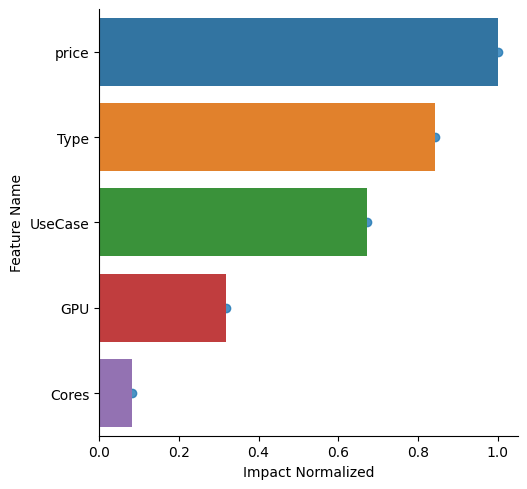

In [35]:
# max features to display
max_num_features = 15

# Retrieve Feature Impact
feature_impacts = top_model.get_or_request_feature_impact()

# Plot permutation-based Feature Impact
feature_impacts.sort(key=lambda x: x["impactNormalized"], reverse=True)
FeatureImpactDF = pd.DataFrame(
    [
        {"Impact Normalized": f["impactNormalized"], "Feature Name": f["featureName"]}
        for f in feature_impacts[:max_num_features]
    ]
)
FeatureImpactDF["X axis"] = FeatureImpactDF.index
g = sns.lmplot(x="Impact Normalized", y="X axis", data=FeatureImpactDF, fit_reg=False)
sns.barplot(y=FeatureImpactDF["Feature Name"], x=FeatureImpactDF["Impact Normalized"]);

In [36]:
# Using the project ID and the model ID, we can construct the URL to click to
print(
    "Project URL: "
    + "https://app.datarobot.com/projects/"
    + project.id
    + "/models/"
    + top_model.id
    + "/feature-impact/"
)

Project URL: https://app.datarobot.com/projects/65a80c81e55b95f8bd6c7eb3/models/65a80d0337807427333bf151/feature-impact/


And the above is the same feature impact plot that you will see in the DataRobot UI, however the UI has a much nicer plot. Which is why I've also generated the URL link to the DataRobot project to look at it side by side 

But from what we can tell, Price followed by Type is the most important attribute. Not too surprising here. Lets check out the feature affects to get more insights on the levels for each attribute. Feature effects is basically partial dependence plot. In conjoint traditional speak, this is how we compute relative utility or partworth for each atrribute level.

In [37]:
import datarobot as dr

project = dr.Project.get("65a80c81e55b95f8bd6c7eb3")
project.id
models = project.get_models()
top_model = models[0]

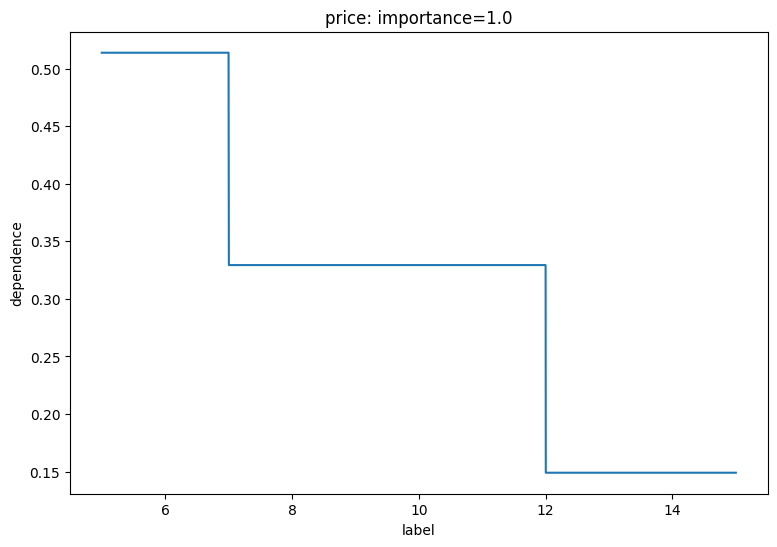

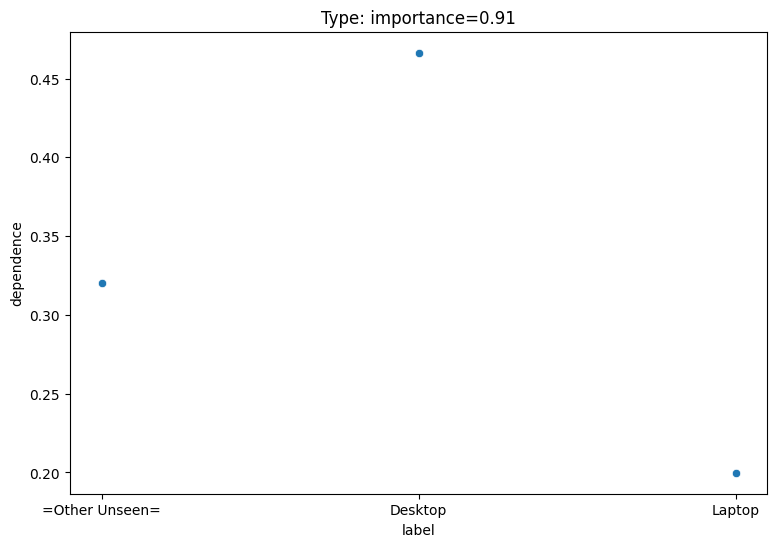

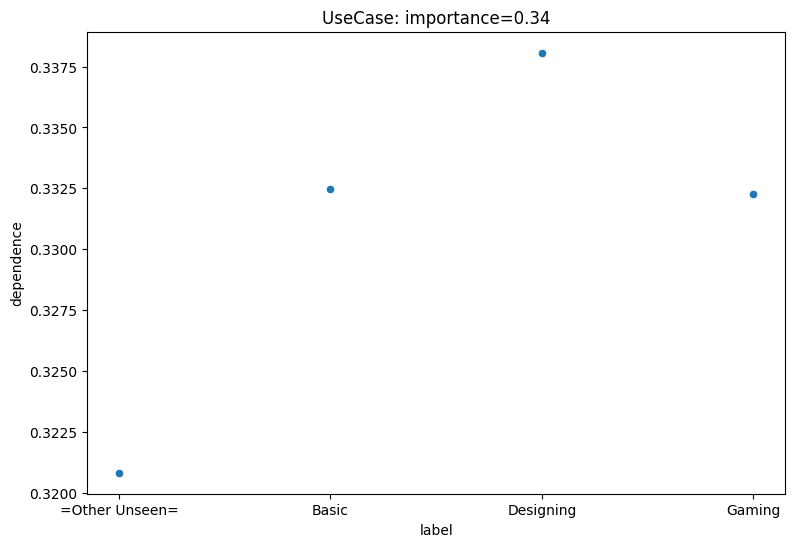

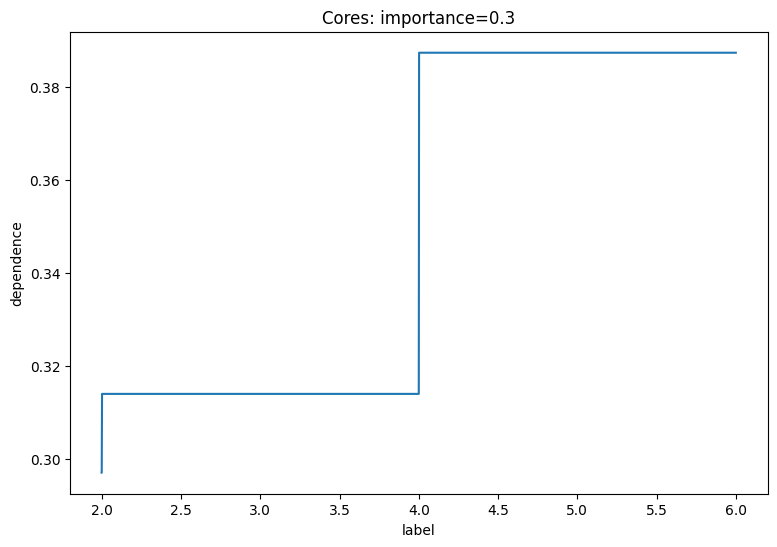

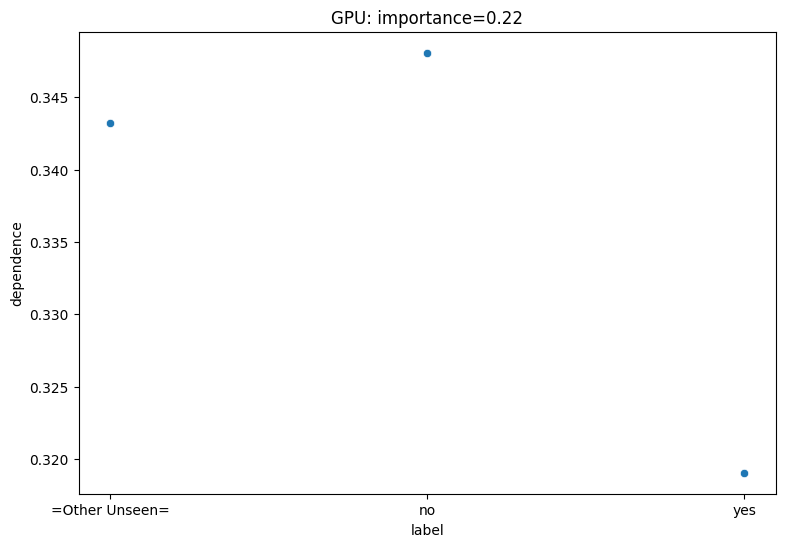

In [38]:
feature_effects = top_model.get_or_request_feature_effect(source="validation")
max_features = 5

for f in feature_effects.feature_effects[:max_features]:
    plt.figure(figsize=(9, 6))
    d = pd.DataFrame(f["partial_dependence"]["data"])
    if f["feature_type"] == "numeric":
        d = d[d["label"] != "nan"]

        try:
            d["label"] = pd.to_numeric(d["label"])
            xtick_rotation = 0
        except ValueError:
            d["label"] = pd.to_datetime(d["label"])
            xtick_rotation = 30

        ax = sns.lineplot(x="label", y="dependence", data=d)
        ax.set_title(f["feature_name"] + ": importance=" + str(round(f["feature_impact_score"], 2)))
        plt.xticks(rotation=xtick_rotation)
    else:
        sns.scatterplot(x="label", y="dependence", data=d).set_title(
            f["feature_name"] + ": importance=" + str(round(f["feature_impact_score"], 2))
        )

In [39]:
# Using the project ID and the model ID, we can construct the URL to click to
print(
    "Project URL: "
    + "https://app.datarobot.com/projects/"
    + project.id
    + "/models/"
    + top_model.id
    + "/feature-effects"
)

Project URL: https://app.datarobot.com/projects/65a80c81e55b95f8bd6c7eb3/models/65a80d0337807427333bf151/feature-effects


As an example of the first plot for the attribute Price, the y-axis represents the prediction probability and the x-axis represent the 3 different price levels of 5, 10, and 15. What this graph is showing is that at the price of 5, the contribution to the probability score (probability of chosing this product) is 0.5. At 10, the contribution drops to 0.32 and at 15 it drops to 0.15. So not surprising people preffer cheaper products.

But keep in mind that the respondents did not evaluate price on its own. Its in consideration with other attributes and they have to trade-offs attributes and features that matters more to them. Lets take a look to other attributes. 

For Type, most people like Desktop over Laptop. For Segment, seems like all 3 segments are pretty equally high which is not surprising since responding from every segment was required to make a choice. For Cores, the more the better. And for GPUs the main preference is no. I suspect this is related to the price aspect.  

Now lets look into prediction explanations:

In [40]:
dr.models.ShapImpact.create(project_id=project.id, model_id=top_model.id)

Job(shapImpact, status=COMPLETED)

In [41]:
# Using the project ID and the model ID, we can construct the URL to click to
print(
    "Project URL: "
    + "https://app.datarobot.com/projects/"
    + project.id
    + "/models/"
    + top_model.id
    + "/shap-prediction-explanations"
)

Project URL: https://app.datarobot.com/projects/65a80c81e55b95f8bd6c7eb3/models/65a80d0337807427333bf151/shap-prediction-explanations


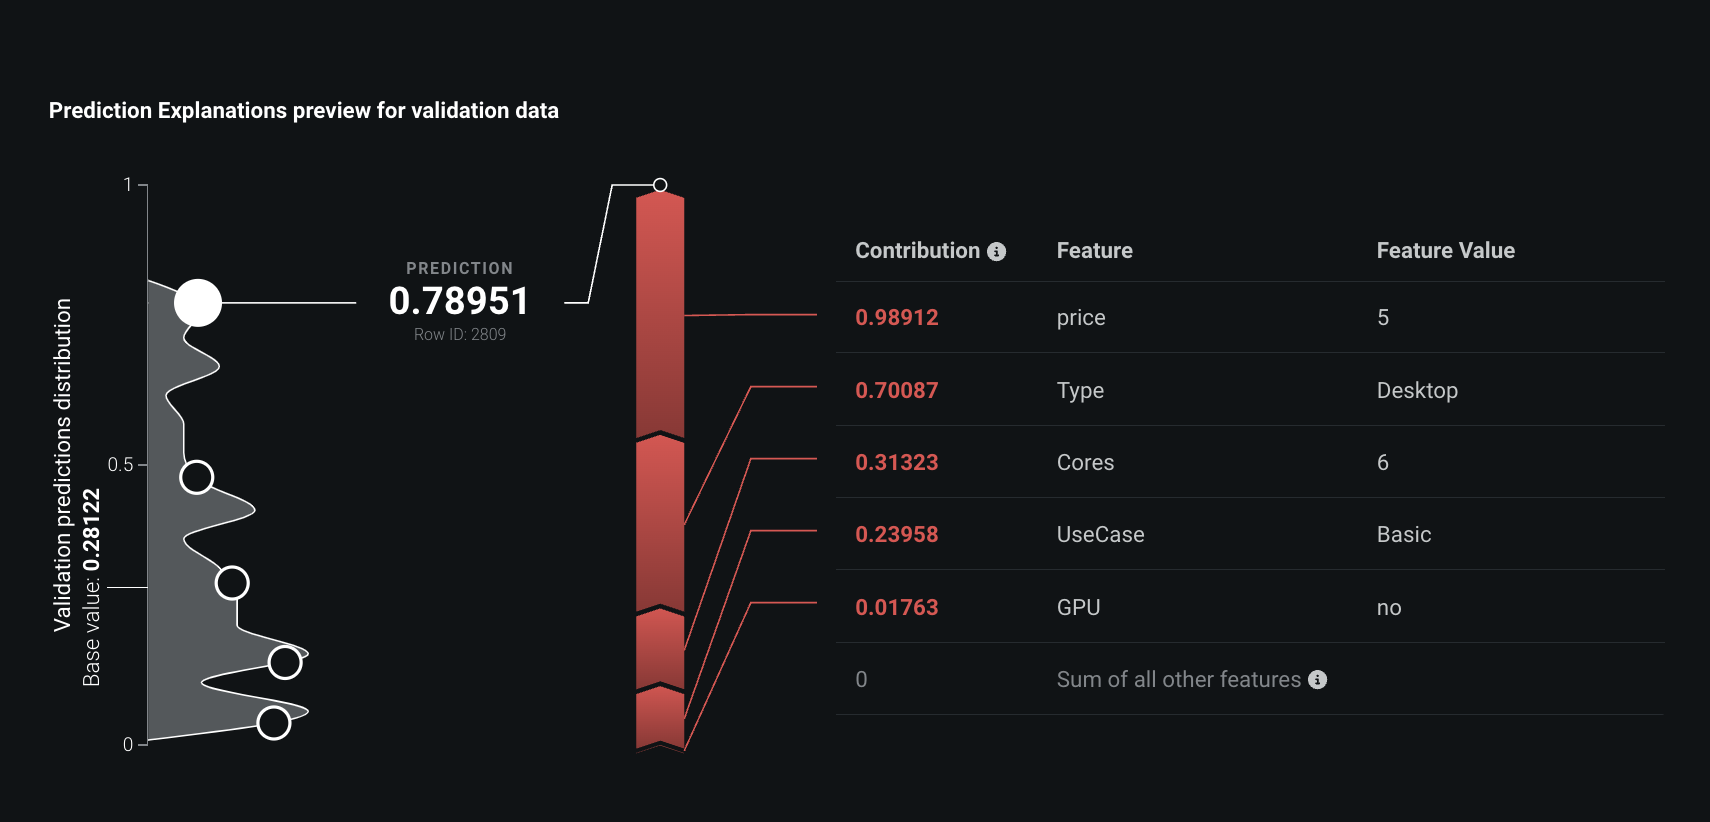

In [35]:
from IPython.display import Image

Image("/home/notebooks/storage/SHAP-explanations.png", width="800", height="400")

The SHAP prediction explanations in summary will give us a view of the best product make up that yields the highest propensity score. In this case one of the best product feature combination looks something like the above image that is taken from DataRobot. 

We take a sample of one of the highest probability scoring product combination at 0.78  (78%) purchase probability 

## Step 6 - Further analysis 

During the qualitative research, it was hypothesised that designers have very specific interest in GPU powered laptops. We know that the Designers segment is under represented here due to the market niche, but in DataRobot we can use Data Slices to focus on the feature affects for this segment.  

In [ ]:
data_slice = dr.DataSlice.create(
    name="Design",
    filters=[{"operand": "UseCase", "operator": "eq", "values": ["Designing"]}],
    project=project,
)

In [71]:
data_slice_id = data_slice_id

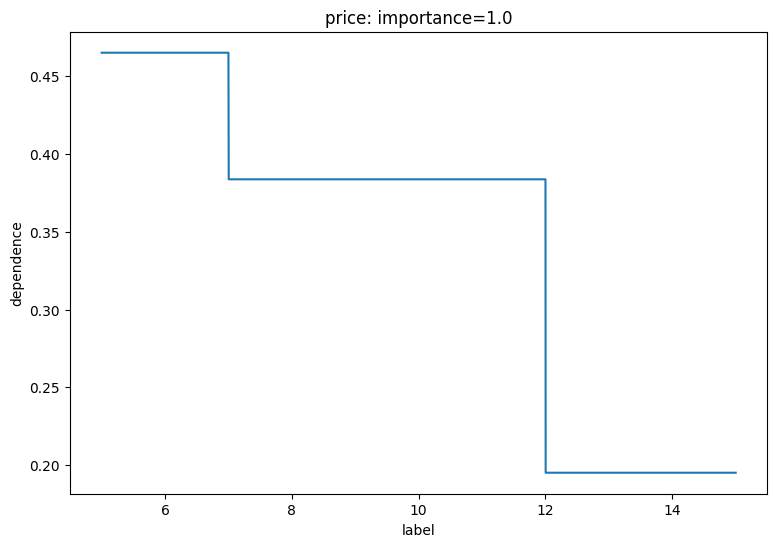

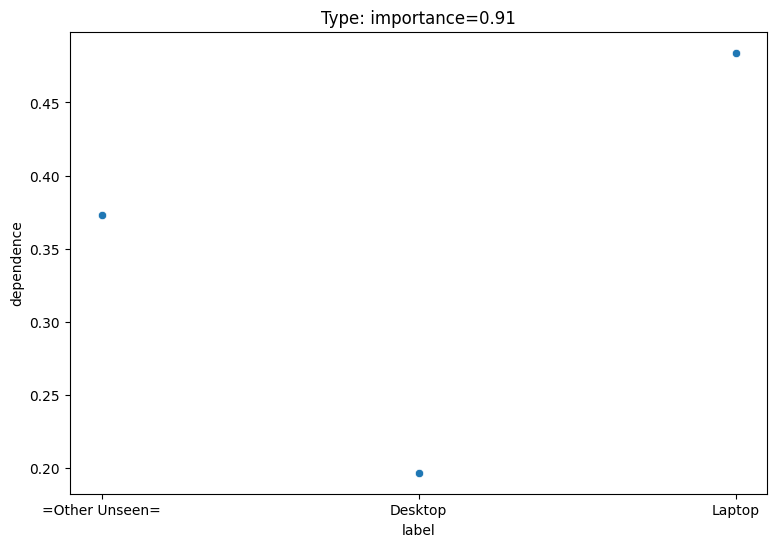

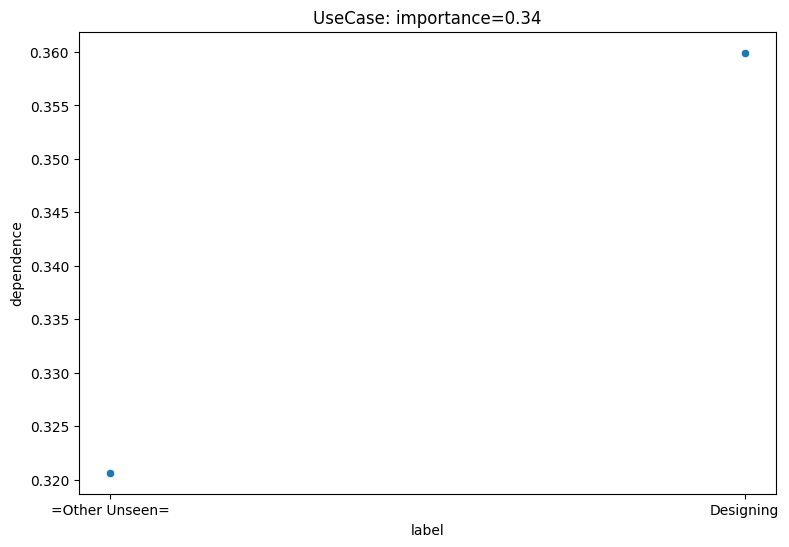

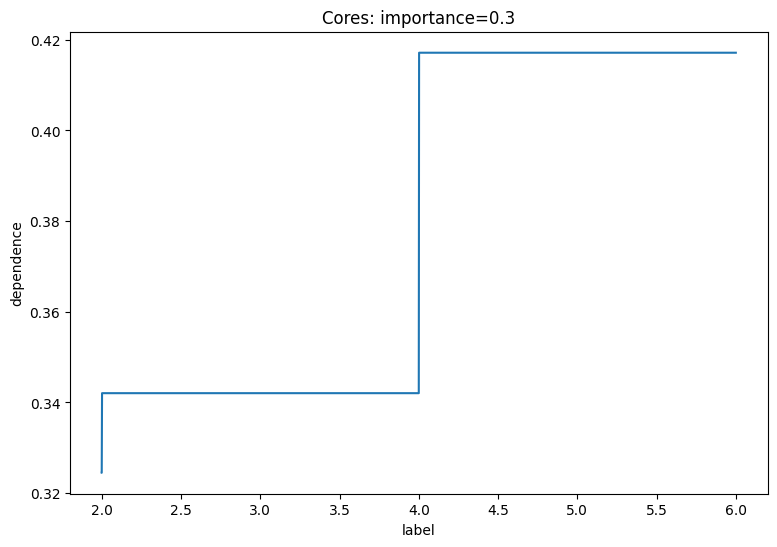

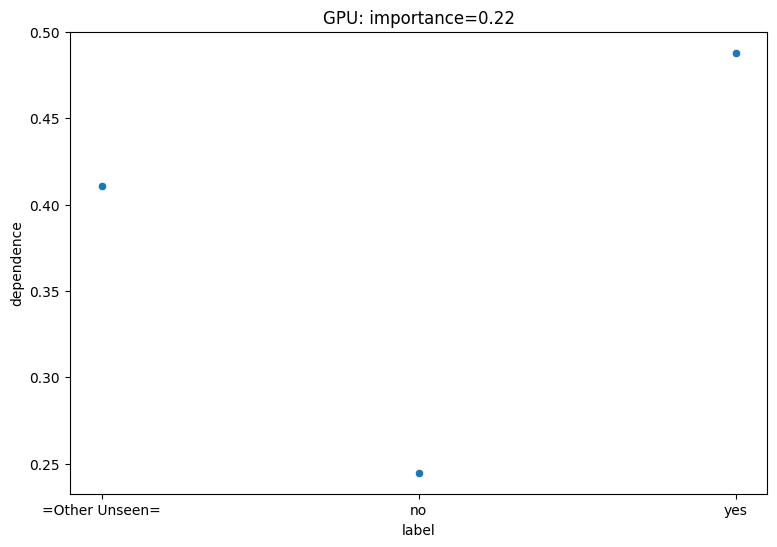

In [72]:
feature_effects_slice = top_model.get_feature_effect(
    source="validation", data_slice_id=data_slice_id
)

max_features = 5

for f in feature_effects_slice.feature_effects[:max_features]:
    plt.figure(figsize=(9, 6))
    d = pd.DataFrame(f["partial_dependence"]["data"])
    if f["feature_type"] == "numeric":
        d = d[d["label"] != "nan"]

        try:
            d["label"] = pd.to_numeric(d["label"])
            xtick_rotation = 0
        except ValueError:
            d["label"] = pd.to_datetime(d["label"])
            xtick_rotation = 30

        ax = sns.lineplot(x="label", y="dependence", data=d)
        ax.set_title(f["feature_name"] + ": importance=" + str(round(f["feature_impact_score"], 2)))
        plt.xticks(rotation=xtick_rotation)
    else:
        sns.scatterplot(x="label", y="dependence", data=d).set_title(
            f["feature_name"] + ": importance=" + str(round(f["feature_impact_score"], 2))
        )

## Step 7 - Model Deployment


In [75]:
prediction_server = dr.PredictionServer.list()[0]

deployment = dr.Deployment.create_from_learning_model(
    top_model.id,
    label="Conjoint Analysis Deployment",
    description="Conjoint Deployment Analysis for surveyed data",
    default_prediction_server_id=prediction_server.id,
)
deployment

Deployment(Conjoint Analysis Deployment)